In [17]:
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torchvision
from tqdm import tqdm
from vit_prisma.models.base_vit import HookedSAEViT
from vit_prisma.models.weight_conversion import convert_timm_weights
from vit_prisma.sae import (SparseAutoencoder, VisionModelSAERunnerConfig, VisionSAETrainer)

from vit.preprocessing import get_processor_for_precached_224_images

def load_models():
    """Load SAE and fine-tuned model"""
    # Load SAE
    sae_path = "./models/sweep/sae_k1024_exp32_lr2e-05/7c6cb9fc-vit_medical_sae_k_sweep/n_images_49276.pt"
    sae = SparseAutoencoder.load_from_pretrained(sae_path)
    sae.cuda().eval()

    # Load model
    model = HookedSAEViT.from_pretrained("vit_base_patch16_224")
    model.head = torch.nn.Linear(model.cfg.d_model, 6)

    checkpoint = torch.load(
        "./model/vit_b-ImageNet_class_init-frozen_False-dataset_Hyperkvasir_anatomical.pth", weights_only=False
    )
    state_dict = checkpoint['model_state_dict'].copy()

    if 'lin_head.weight' in state_dict:
        state_dict['head.weight'] = state_dict.pop('lin_head.weight')
    if 'lin_head.bias' in state_dict:
        state_dict['head.bias'] = state_dict.pop('lin_head.bias')

    converted_weights = convert_timm_weights(state_dict, model.cfg)
    model.load_state_dict(converted_weights)
    model.cuda().eval()

    return sae, model

sae, model = load_models()

2025-07-09 14:01:45 INFO:root: get_activation_fn received: activation_fn=topk, kwargs={'k': 1024}
2025-07-09 14:01:45 WARNING:root: Model 'vit_base_patch16_224' is not in the lists of models passing or failing tests. Unclear status. You may want to check that the HookedViT matches the original model under tests/test_loading_clip.py.
2025-07-09 14:01:46 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (9): huggingface.co:443


ln_pre not set


2025-07-09 14:01:46 INFO:timm.models._builder: Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)
2025-07-09 14:01:46 DEBUG:urllib3.connectionpool: Starting new HTTPS connection (10): huggingface.co:443
2025-07-09 14:01:46 INFO:timm.models._hub: [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-07-09 14:01:46 INFO:root: Filling in 2 missing keys with default initialization
2025-07-09 14:01:46 WARNING:root: Missing key for weight matrix: head.W_H
2025-07-09 14:01:47 INFO:root: Loaded pretrained model vit_base_patch16_224 into HookedTransformer


Converting the weights of a timm model to a Prisma ViT
LayerNorm folded.
Centered weights writing to residual stream
Converting the weights of a timm model to a Prisma ViT


In [18]:
from vit_prisma.sae import SparsecoderEval

label_map = {2: 3, 3: 2}  # original label 0 -> new label 2, original label 1 -> new label 0

def custom_target_transform(target):
    return label_map.get(target, target)

val_path = "./hyper-kvasir_imagefolder/val"
val_dataset = torchvision.datasets.ImageFolder(val_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)
eval_runner = SparsecoderEval(sae, model, val_dataset)

In [19]:
# Evaluate vision SAE
metrics = eval_runner.run_eval(is_clip=False)

2025-07-09 14:01:47 INFO:vit_prisma.sae.evals.model_eval: Starting SparseCoder evaluation...
Evaluating: 100%|██████████| 103/103 [00:05<00:00, 18.23it/s, L0=15919, Cosine Sim=0.820421]   
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Finished running through validation dataset...
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Computing metrics...
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated): 1024.000000
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per CLS token: 1024.000000
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average L0 (features activated) per image: 15379.441463
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average Cosine Similarity: 0.8024
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average Loss: 0.106716
2025-07-09 14:01:52 INFO:vit_prisma.sae.evals.model_eval: Average Reconstruction Loss: 0.141882
2025-07-09 14:01:52 INFO

In [20]:
import itertools
# run on a few batches
with torch.no_grad():
    alive = torch.zeros(sae.cfg.d_sae, dtype=torch.bool).cuda()
    for imgs,_ in val_loader:   # ~2 000 images
        acts = model.run_with_cache(imgs.cuda(),
                                    names_filter=sae.cfg.hook_point)[1][sae.cfg.hook_point]
        act, h, *_ = sae.encode(acts)
        alive |= (h != 0).any(0).any(0)

alive_cnt = int(alive.sum())
print(f"number of units that ever fire : {alive_cnt}")
dead_features = ~alive
print(f"Dead features: {dead_features.sum()}/{len(alive)}")

number of units that ever fire : 24560
Dead features: 16/24576


/tmp/ipykernel_10288/1165344330.py:5: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

2025-07-08 16:42:55 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-08 16:42:55 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/

2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-BoldOblique.ttf', name='Purisa', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush.ttf', name='Umpush', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-07-08 16:42:55 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/usr/share/fonts/truetype/pagul/Pagul.ttf', name='Pagul', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-08 16:42:55 DEBU

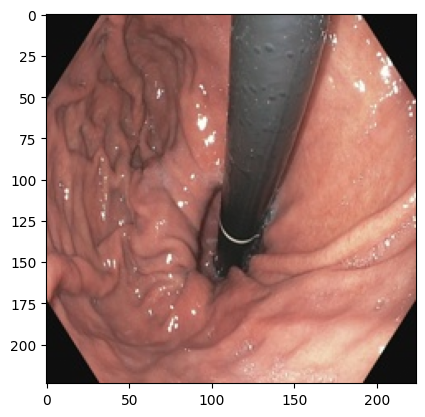

In [5]:
from PIL import Image

def imshow(img_tensor, mean, std):
  img = img_tensor.permute(1, 2, 0).cpu().numpy()
  img = std * img + mean
  plt.imshow(img)

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])


img = Image.open("./hyper-kvasir_imagefolder/val/retroflex-stomach/0f8374f1-d6d3-4450-83a8-924aa831e943.jpg")
transform = get_processor_for_precached_224_images()
img = transform(img)
imshow(img, mean=mean, std=std)

In [122]:
output, cache = model.run_with_cache(img.unsqueeze(0).to('cuda'), names_filter=sae.cfg.hook_point)
activations = cache[sae.cfg.hook_point]
output, feature_acts, *data = sae.encode(activations)

print(output.shape)
print(feature_acts.shape)

from vit_prisma.utils.tutorial_utils import plot_act_distribution

feature_acts_cls = feature_acts[:, 0, :]
top_indices, _ = plot_act_distribution(feature_acts_cls.squeeze(0), n_top=5)

torch.Size([1, 197, 768])
torch.Size([1, 197, 3072])
Top 5 feature indices: [2245, 2270, 2200, 938, 3059]
Top 5 feature values: [30.165169 30.888874 31.327335 32.794544 34.909348]


In [2]:
val_path = "./hyper-kvasir_imagefolder/val"
val_dataset = torchvision.datasets.ImageFolder(val_path, get_processor_for_precached_224_images())
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

In [41]:
train_path = "./hyper-kvasir_imagefolder/train"
train_dataset = torchvision.datasets.ImageFolder(train_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

In [4]:
test_path = "./hyper-kvasir_imagefolder/test"
test_dataset = torchvision.datasets.ImageFolder(test_path, get_processor_for_precached_224_images(), target_transform=custom_target_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [51]:
# PART TWO: What are these SAE features?
from tqdm.notebook import tqdm

# datastructure that captures top n values of given features and corresponding image indices of those values so we can retrieve those images later
top_image_indices = {}
for feature_id in top_indices:
  top_image_indices[feature_id] = {
      'values': [], # 20 values
      'dataset_indices': [] # 20
  }


top_k = 20
# iterate through dataset

start_idx = 0
for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
  batch_images = image.to('cuda')
  batch_labels = label.to('cuda')

  batch_size = batch_images.shape[0]

  # feed into model
  output, cache = model.run_with_cache(batch_images, names_filter = sae.cfg.hook_point)

  # cache activations at layer 10 mlp out
  activations = cache[sae.cfg.hook_point]
  output, feature_acts, *data = sae(activations)
  feature_acts_cls = feature_acts[:, 0, top_indices]

  for i, feature_id in enumerate(top_indices):

      values = feature_acts_cls[:, i].detach().cpu().numpy()
      dataset_indices = list(range(start_idx, start_idx + batch_size)) # global indices to retrieve the images from the non-shuffled dataset later

      for val, idx in zip(values, dataset_indices):

        current_values = top_image_indices[feature_id]['values']
        current_indices = top_image_indices[feature_id]['dataset_indices']

        if len(current_values) < top_k:
          current_values.append(val)
          current_indices.append(idx)
        else:
          min_val = min(current_values)
          if val > min_val:
            min_idx = current_values.index(min_val)
            current_values[min_idx] = val
            current_indices[min_idx] = idx

  start_idx += batch_size

0it [00:00, ?it/s]

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_features(top_activations_dict, viz_data, cfg=None, num_features=5):
    feature_indices = sorted(top_activations_dict.keys())[:num_features]  # limit to num_features

    for feature_idx in feature_indices:
        feature_data = top_activations_dict[feature_idx]
        activation_values = feature_data['values']
        activation_indices = feature_data['dataset_indices']

        grid_size = int(np.ceil(np.sqrt(len(activation_indices))))
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
        fig.suptitle(f'Feature {feature_idx}', fontsize=16)

        # Flatten axes for easy indexing
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for i, (image_idx, act_value) in enumerate(zip(activation_indices, activation_values)):
            if i >= len(axes):
                break  # avoid index error if more images than axes

            img, label = viz_data[image_idx]
            img = img.detach().cpu().numpy().transpose(1, 2, 0)  # CHW -> HWC

            # De-normalize (assuming standard ImageNet normalization)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)

            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f'Act: {act_value:.2f}')
            ax.axis('off')

        # Hide unused axes
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Leave space for suptitle
        plt.show()


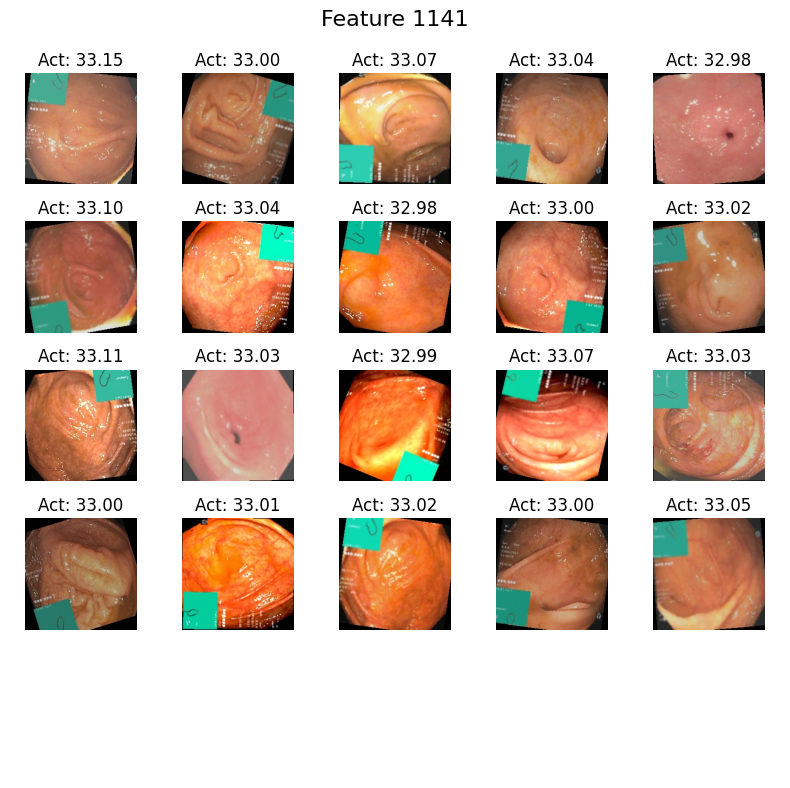

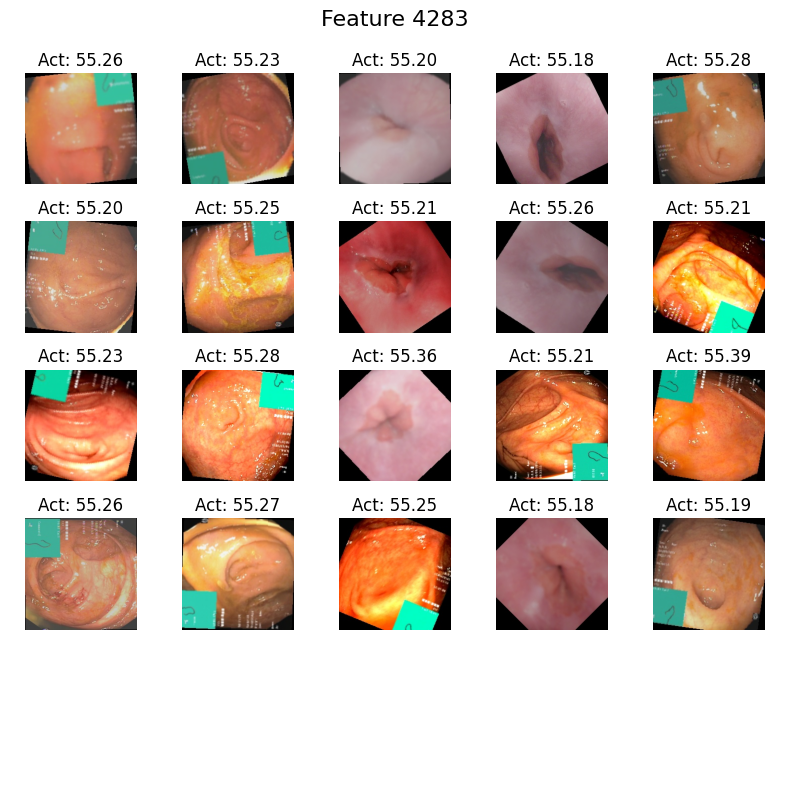

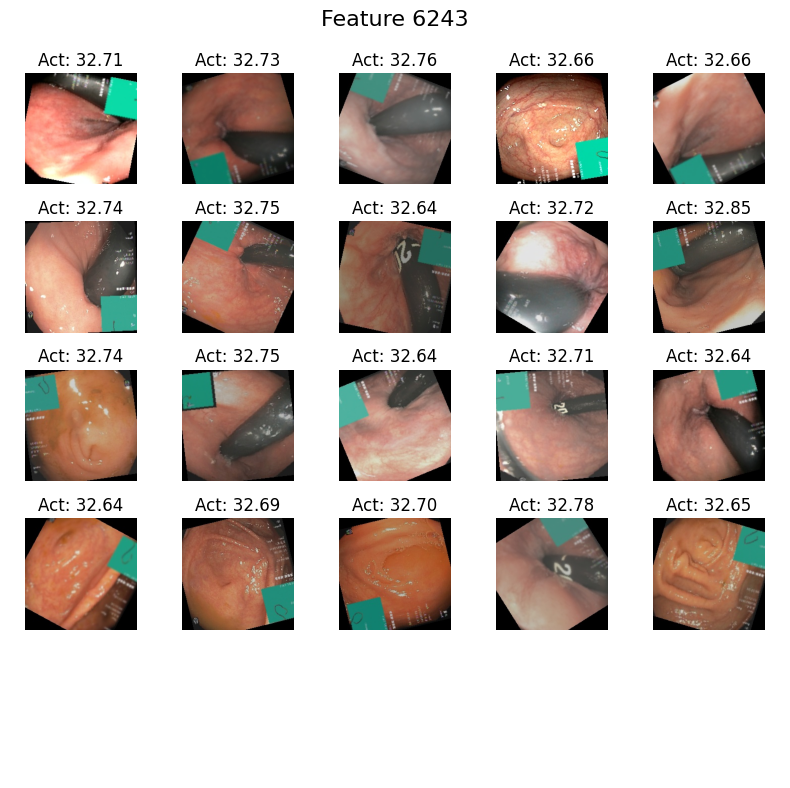

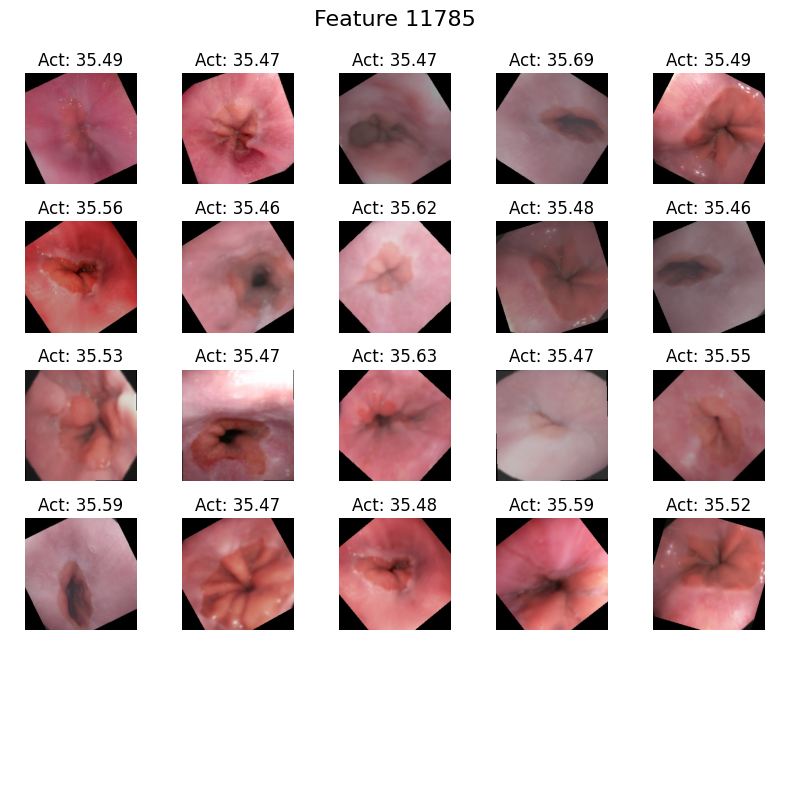

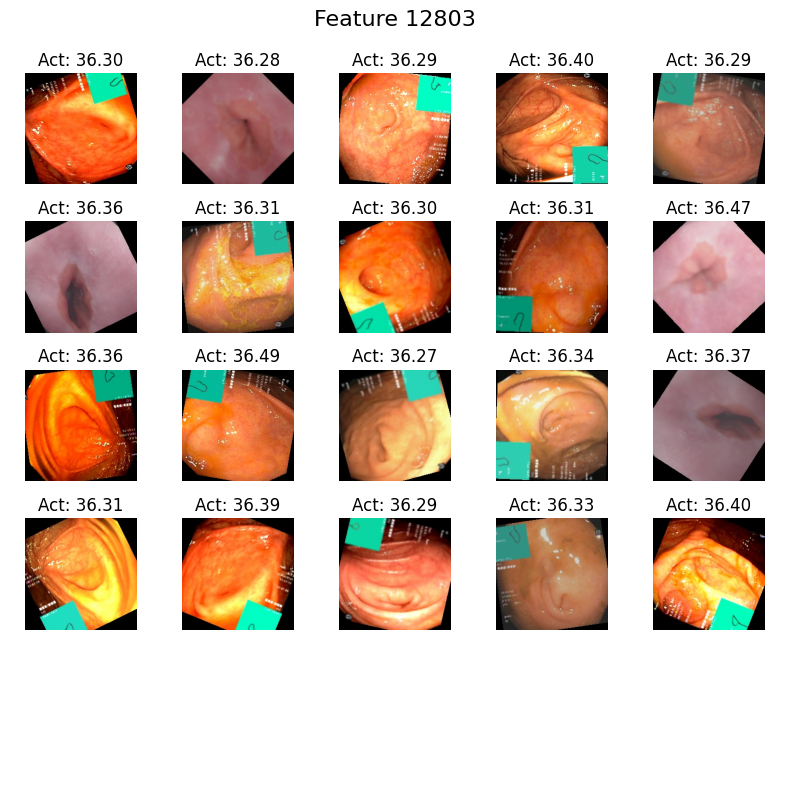

In [59]:
plot_all_features(top_image_indices, train_dataset, sae.cfg, num_features = 5)

In [128]:
from collections import Counter, defaultdict
import torch

k = 32                                            # how many features per image
n_features = sae.cfg.d_sae                        # number of SAE features
n_classes  = len(train_dataset.classes)           # 6 in your case

global_counter      = Counter()                   # feature → occurrences
per_class_counter   = defaultdict(Counter)        # class_id → Counter

# Optional: ndarray if you prefer a matrix later
feature_class_matrix = torch.zeros(n_features, n_classes, dtype=torch.int32)

@torch.no_grad()
def collect_topk_statistics(loader):
    for imgs, labels in tqdm(loader, desc="Counting top-k features"):
        imgs, labels = imgs.cuda(), labels.cuda()

        _, cache      = model.run_with_cache(imgs, names_filter=sae.cfg.hook_point)
        activations   = cache[sae.cfg.hook_point]                 # [B, seq, d_model]
        feats  = sae.encode(activations)[1]                  # [B, seq, d_sae]
        feats_cls     = feats[:, 0, :]                            # [B, d_sae]

        # top-k indices for every example in the batch
        _, top_idx = torch.topk(feats_cls, k=k, dim=-1)          # [B, k]

        for idxs, cls in zip(top_idx.cpu(), labels.cpu()):
            idxs = idxs.tolist()
            global_counter.update(idxs)
            per_class_counter[int(cls)].update(idxs)
            feature_class_matrix[idxs, cls] += 1

collect_topk_statistics(train_loader)

Counting top-k features: 100%|██████████| 4105/4105 [01:11<00:00, 57.76it/s]


=== Globally most common features ===
Feature  2669: 16420
Feature   586: 16420
Feature  1553: 16420
Feature  1017: 16420
Feature  2986: 16420
Feature   419: 16420
Feature  2943: 16420
Feature   783: 16420
Feature   268: 16420
Feature  2698: 16420
Feature  2964: 16420
Feature   939: 16420
Feature  1272: 16420
Feature  1036: 16420
Feature  2500: 16420
Feature  1649: 16420
Feature   613: 16420
Feature  2743: 16420
Feature  1184: 16420
Feature   158: 16420

=== Per-class breakdown (top 10 features each) ===

Class: cecum
    Feature  2669: 3970
    Feature   586: 3970
    Feature  1553: 3970
    Feature  1017: 3970
    Feature  2986: 3970
    Feature   419: 3970
    Feature  2943: 3970
    Feature   783: 3970
    Feature   268: 3970
    Feature  2698: 3970

Class: ileum
    Feature  2669: 30
    Feature  1553: 30
    Feature   586: 30
    Feature  2986: 30
    Feature  1017: 30
    Feature   419: 30
    Feature   783: 30
    Feature  2943: 30
    Feature   268: 30
    Feature  2698: 30

C

cecum  ileum  pylorus  retroflex-rectum  retroflex-stomach  z-line  \
2698   3970     30     1540              4080               3050    3750   
1184   3970     30     1540              4080               3050    3750   
2609   3970     30     1540              4080               3050    3750   
2743   3970     30     1540              4080               3050    3750   
2986   3970     30     1540              4080               3050    3750   
1649   3970     30     1540              4080               3050    3750   
2964   3970     30     1540              4080               3050    3750   
2943   3970     30     1540              4080               3050    3750   
419    3970     30     1540              4080               3050    3750   
1036   3970     30     1540              4080               3050    3750   
268    3970     30     1540              4080               3050    3750   
924    3970     30     1540              4080               3050    3750   
158    3970     30     1540              4080               3050    3750   
1017   3970     30     1540              4080               3050    3750   
939    3970     30     1540              4080               3050    3750   
613    3970     30     1540              4080               3050    3750   
2500   3970     30     1540              4080               3050    3750   
586    3970     30     1540              4080               3050    3750   
1272   3970     30     1540              4080               3050    3750   
1553   3970     30     1540              4080               3050    3750   

      TOTAL  
2698  16420  
1184  16420  
2609  16420  
2743  16420  
2986  16420  
1649  16420  
2964  16420  
2943  16420  
419   16420  
1036  16420  
268   16420  
924   16420  
158   16420  
1017  16420  
939   16420  
613   16420  
2500  16420  
586   16420  
1272  16420  
1553  16420

2025-06-12 12:49:54 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x706374532170>


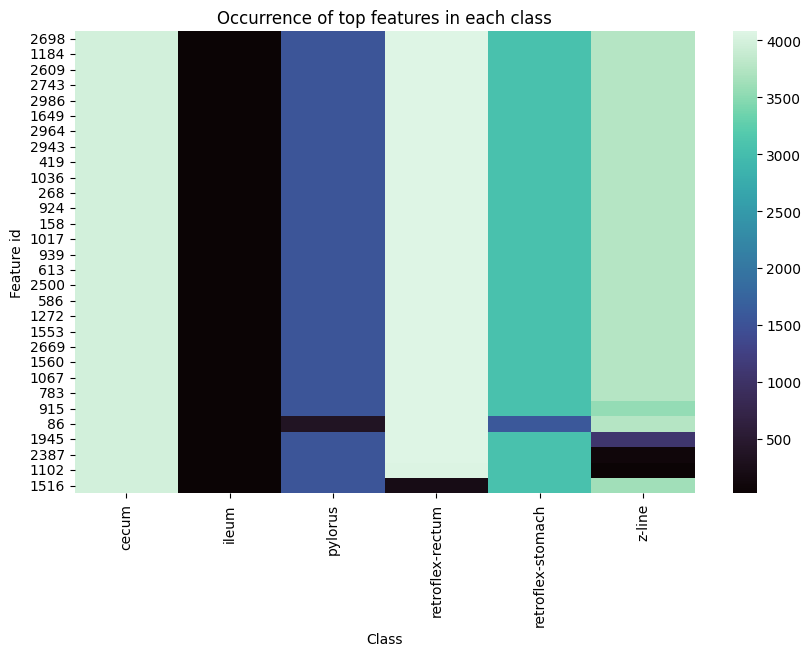

In [129]:
import pandas as pd

# How many times did each feature appear in the global top-k list?
print("=== Globally most common features ===")
for feat, cnt in global_counter.most_common(20):
    print(f"Feature {feat:5d}: {cnt}")

# Per-class breakdown --------------------------------------------------------
print("\n=== Per-class breakdown (top 10 features each) ===")
for class_id, counter in per_class_counter.items():
    class_name = train_dataset.classes[class_id]
    print(f"\nClass: {class_name}")
    for feat, cnt in counter.most_common(10):
        print(f"    Feature {feat:5d}: {cnt}")

# Nice tabular overview ------------------------------------------------------
# rows = features, columns = classes + TOTAL
df = pd.DataFrame(feature_class_matrix.numpy(),
                  columns=train_dataset.classes)
df["TOTAL"] = df.sum(axis=1)

# Show 20 most frequent features overall
display(df.sort_values("TOTAL", ascending=False).head(20))

# … or for a heat-map like view
import seaborn as sns; import matplotlib.pyplot as plt
top_feats = df.sort_values("TOTAL", ascending=False).head(30).index
plt.figure(figsize=(10,6))
sns.heatmap(df.loc[top_feats, train_dataset.classes],
            cmap="mako", annot=False)
plt.title("Occurrence of top features in each class")
plt.ylabel("Feature id"); plt.xlabel("Class")
plt.show()

In [130]:
@torch.no_grad()
def debug_feature_diversity_fixed(model, sae, train_loader):
    """Check if SAE produces diverse features across images"""
    
    all_top_features = []
    
    for i, (imgs, labels) in enumerate(train_loader):
        if i >= 5:
            break
            
        imgs = imgs.cuda()
        _, cache = model.run_with_cache(imgs, names_filter=sae.cfg.hook_point)
        activations = cache[sae.cfg.hook_point][:, 0:1, :]  # CLS only, shape: [B, 1, 768]
        
        # This is the fix - you need to call sae.encode()!
        features = sae.encode(activations)  # Shape: [B, 1, 24576]
        features = features[1].squeeze(1)  # Shape: [B, 24576]
        print(features.shape)
        
        print(f"\nBatch {i}:")
        print(f"Activation shape: {activations.shape}")
        print(f"Feature shape: {features.shape}")
        print(f"Non-zero features per image: {(features > 0).sum(dim=1).tolist()}")
        
        # Get top-k
        top_vals, top_idx = features.topk(k=550, dim=-1)
        
        # Check overlap
        first_set = set(top_idx[0].cpu().tolist())
        for j in range(1, min(4, len(top_idx))):
            current_set = set(top_idx[j].cpu().tolist())
            overlap = len(first_set & current_set)
            print(f"  Image 0 vs Image {j}: {overlap}/32 features overlap")

debug_feature_diversity_fixed(model, sae, val_loader)

torch.Size([4, 3072])

Batch 0:
Activation shape: torch.Size([4, 1, 768])
Feature shape: torch.Size([4, 3072])
Non-zero features per image: [131, 132, 131, 132]
  Image 0 vs Image 1: 549/32 features overlap
  Image 0 vs Image 2: 548/32 features overlap
  Image 0 vs Image 3: 548/32 features overlap
torch.Size([4, 3072])

Batch 1:
Activation shape: torch.Size([4, 1, 768])
Feature shape: torch.Size([4, 3072])
Non-zero features per image: [130, 131, 133, 132]
  Image 0 vs Image 1: 548/32 features overlap
  Image 0 vs Image 2: 546/32 features overlap
  Image 0 vs Image 3: 547/32 features overlap
torch.Size([4, 3072])

Batch 2:
Activation shape: torch.Size([4, 1, 768])
Feature shape: torch.Size([4, 3072])
Non-zero features per image: [141, 133, 131, 132]
  Image 0 vs Image 1: 537/32 features overlap
  Image 0 vs Image 2: 536/32 features overlap
  Image 0 vs Image 3: 538/32 features overlap
torch.Size([4, 3072])

Batch 3:
Activation shape: torch.Size([4, 1, 768])
Feature shape: torch.Size([4,

100%|██████████| 103/103 [00:01<00:00, 55.95it/s]
2025-06-12 12:50:12 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x7063757d2ad0>



=== Most Discriminative Features ===
Feature   254: score=989795.9, best for z-line (freq=0.99 vs others=0.000)
Feature   214: score=938775.5, best for z-line (freq=0.94 vs others=0.000)
Feature   191: score=687500.0, best for pylorus (freq=0.69 vs others=0.000)
Feature   363: score=653061.2, best for z-line (freq=0.65 vs others=0.000)
Feature   469: score=602040.8, best for z-line (freq=0.60 vs others=0.000)
Feature   163: score=61224.5, best for z-line (freq=0.06 vs others=0.000)
Feature   636: score=31250.0, best for pylorus (freq=0.03 vs others=0.000)
Feature   448: score=30612.2, best for z-line (freq=0.03 vs others=0.000)
Feature   136: score=24390.2, best for retroflex-stomach (freq=0.02 vs others=0.000)
Feature   190: score=10204.1, best for z-line (freq=0.01 vs others=0.000)
Feature   728: score=10204.1, best for z-line (freq=0.01 vs others=0.000)
Feature   197: score= 219.3, best for pylorus (freq=0.94 vs others=0.004)
Feature    80: score=  91.4, best for z-line (freq=0.57 

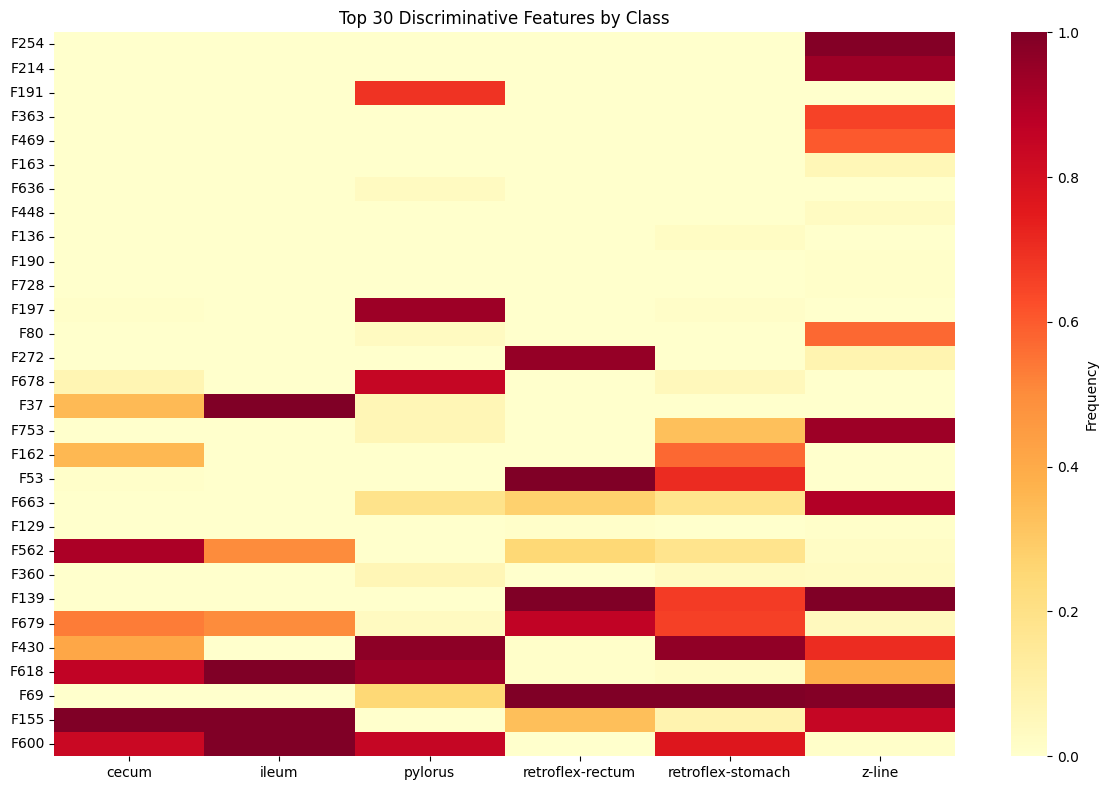


=== Top Features Per Class ===

cecum:
    Feature   523:  109 times (100.00%)
  * Feature   374:  109 times (100.00%)
  * Feature   175:  109 times (100.00%)
  * Feature    58:  109 times (100.00%)
  * Feature    19:  109 times (100.00%)
  * Feature   159:  109 times (100.00%)
  * Feature   226:  109 times (100.00%)
    Feature   464:  109 times (100.00%)
  * Feature    63:  109 times (100.00%)
  * Feature   393:  109 times (100.00%)
  Total samples: 109

ileum:
    Feature   523:    2 times (100.00%)
    Feature   374:    2 times (100.00%)
    Feature   175:    2 times (100.00%)
    Feature    58:    2 times (100.00%)
    Feature   159:    2 times (100.00%)
    Feature    19:    2 times (100.00%)
    Feature   226:    2 times (100.00%)
    Feature   464:    2 times (100.00%)
    Feature   597:    2 times (100.00%)
    Feature    63:    2 times (100.00%)
  Total samples: 2

pylorus:
    Feature   523:   32 times (100.00%)
    Feature   374:   32 times (100.00%)
    Feature    19:   3

In [131]:
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@torch.no_grad()
def analyze_class_features(model, sae, train_loader, n_classes=6):
    """Comprehensive feature analysis per class"""
    
    # Storage
    class_feature_counts = defaultdict(Counter)  # class -> feature -> count
    class_feature_values = defaultdict(list)     # class -> list of (feature_id, value)
    total_samples_per_class = Counter()
    
    print("Collecting features...")
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.cuda(), labels.cuda()
        
        # Get features
        _, cache = model.run_with_cache(imgs, names_filter=sae.cfg.hook_point)
        activations = cache[sae.cfg.hook_point][:, 0:1, :]  # CLS only
        features = sae.encode(activations)[0].squeeze(1)  # [B, d_sae]
        
        # For each image
        for feats, label in zip(features, labels):
            label = label.item()
            total_samples_per_class[label] += 1
            
            # Get top-k features and their values
            top_vals, top_idx = feats.topk(k=32)
            
            # Count occurrences
            for idx, val in zip(top_idx.cpu().tolist(), top_vals.cpu().tolist()):
                class_feature_counts[label][idx] += 1
                class_feature_values[label].append((idx, val))
    
    return class_feature_counts, class_feature_values, total_samples_per_class

# Run analysis
class_feature_counts, class_feature_values, total_samples = analyze_class_features(
    model, sae, val_loader
)

# Find discriminative features
def find_discriminative_features(class_feature_counts, total_samples, n_classes=6):
    """Find features that are specific to certain classes"""
    
    # Convert to frequency matrix
    all_features = set()
    for counts in class_feature_counts.values():
        all_features.update(counts.keys())
    
    # Create frequency matrix
    freq_matrix = np.zeros((len(all_features), n_classes))
    feature_list = sorted(list(all_features))
    
    for class_idx in range(n_classes):
        for feat_idx, feature in enumerate(feature_list):
            count = class_feature_counts[class_idx].get(feature, 0)
            freq = count / total_samples[class_idx] if total_samples[class_idx] > 0 else 0
            freq_matrix[feat_idx, class_idx] = freq
    
    # Calculate discriminative scores
    discriminative_scores = []
    for feat_idx, feature in enumerate(feature_list):
        freqs = freq_matrix[feat_idx]
        if freqs.max() > 0:
            # Ratio of max frequency to mean of others
            max_class = freqs.argmax()
            max_freq = freqs[max_class]
            other_freqs = np.concatenate([freqs[:max_class], freqs[max_class+1:]])
            mean_other = other_freqs.mean() if len(other_freqs) > 0 else 0
            
            score = max_freq / (mean_other + 1e-6)
            discriminative_scores.append({
                'feature': feature,
                'score': score,
                'max_class': max_class,
                'max_freq': max_freq,
                'mean_other_freq': mean_other
            })
    
    # Sort by discriminative score
    discriminative_scores.sort(key=lambda x: x['score'], reverse=True)
    
    return discriminative_scores, freq_matrix, feature_list

disc_scores, freq_matrix, feature_list = find_discriminative_features(
    class_feature_counts, total_samples
)

# Print results
print("\n=== Most Discriminative Features ===")
class_names = ['cecum', 'ileum', 'pylorus', 'retroflex-rectum', 'retroflex-stomach', 'z-line']

for i, item in enumerate(disc_scores[:20]):
    feat = item['feature']
    score = item['score']
    max_class = item['max_class']
    print(f"Feature {feat:5d}: score={score:6.1f}, "
          f"best for {class_names[max_class]} "
          f"(freq={item['max_freq']:.2f} vs others={item['mean_other_freq']:.3f})")

# Visualize top discriminative features
top_n = 30
top_features = [item['feature'] for item in disc_scores[:top_n]]
top_indices = [feature_list.index(f) for f in top_features]

plt.figure(figsize=(12, 8))
sns.heatmap(freq_matrix[top_indices, :], 
            xticklabels=class_names,
            yticklabels=[f"F{f}" for f in top_features],
            cmap='YlOrRd',
            cbar_kws={'label': 'Frequency'})
plt.title('Top 30 Discriminative Features by Class')
plt.tight_layout()
plt.show()

# Per-class analysis
print("\n=== Top Features Per Class ===")
for class_idx, class_name in enumerate(class_names):
    print(f"\n{class_name}:")
    class_counts = class_feature_counts[class_idx]
    total = total_samples[class_idx]
    
    # Get top 10 most frequent
    for feat, count in class_counts.most_common(10):
        freq = count / total
        # Check if it's discriminative
        is_discriminative = any(item['feature'] == feat and item['max_class'] == class_idx 
                               for item in disc_scores[:50])
        marker = "*" if is_discriminative else " "
        print(f"  {marker} Feature {feat:5d}: {count:4d} times ({freq:.2%})")
    
    print(f"  Total samples: {total}")

In [140]:
from collections import Counter, defaultdict
import numpy as np, torch, itertools
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm

# -----------------------------------------------------------
# 1)  Collect counts *and* sums of activations  (NEW/CHANGED)
# -----------------------------------------------------------
@torch.no_grad()
def analyze_class_features(model, sae, loader, n_classes=6, k=200):
    """
    Returns
        counts[class_id][feature] -> #images whose top-k contains feature
        sums  [class_id][feature] -> sum of activation values (pre-topk mask)
        totals[class_id]          -> #images in that class
    """
    counts = defaultdict(Counter)                      # was class_feature_counts
    sums   = defaultdict(lambda: defaultdict(float))   # NEW
    totals = Counter()

    print("Collecting features...")
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.cuda(), labels.cuda()

        # CLS activations
        _, cache = model.run_with_cache(imgs, names_filter=sae.cfg.hook_point)
        acts = cache[sae.cfg.hook_point][:, 0:1, :]          # (B,1,d_in)
        feats = sae.encode(acts)[1].squeeze(1)               # (B,d_sae)

        # iterate over batch
        for fvec, lbl in zip(feats, labels):
            lbl = lbl.item()
            totals[lbl] += 1

            top_val, top_idx = fvec.topk(k=k, largest=True)
            for idx, val in zip(top_idx, top_val):
                idx = idx.item()
                counts[lbl][idx] += 1
                sums  [lbl][idx] += val.item()               # NEW

    return counts, sums, totals
# -----------------------------------------------------------

counts, sums, totals = analyze_class_features(model, sae, train_loader)

# -----------------------------------------------------------------
# 2)  Helper that returns mean activation for one class / feature
# -----------------------------------------------------------------
def mean_act(class_id, feat_id):
    return sums[class_id][feat_id] / counts[class_id][feat_id]

# -----------------------------------------------------------
# 3)  Your discriminative-feature code remains unchanged
# -----------------------------------------------------------
disc_scores, freq_matrix, feature_list = find_discriminative_features(
    counts, totals
)

# -----------------------------------------------------------
# 4)  Print top features per class *with* mean activation
# -----------------------------------------------------------
class_names = ['cecum', 'ileum', 'pylorus',
               'retroflex-rectum', 'retroflex-stomach', 'z-line']

print("\n=== Top Features Per Class ===")
for c, cname in enumerate(class_names):
    print(f"\n{cname}:")
    total = totals[c]
    for feat, n in counts[c].most_common(200):
        freq = n / total
        avg_act = mean_act(c, feat)
        discr  = any(d['feature']==feat and d['max_class']==c for d in disc_scores[:200])
        mark   = "*" if discr else " "
        print(f" {mark} Feature {feat:5d}: {n:4d}× "
              f"({freq:6.2%})  avg|act|={avg_act:6.3f}")
    print(f"  Total samples: {total}")


100%|██████████| 4105/4105 [01:41<00:00, 40.61it/s]


=== Top Features Per Class ===

cecum:
   Feature  4723: 3970× (100.00%)  avg|act|=16.997
   Feature  5301: 3970× (100.00%)  avg|act|=13.919
   Feature  1196: 3970× (100.00%)  avg|act|=12.305
   Feature  5590: 3970× (100.00%)  avg|act|=11.478
   Feature   254: 3970× (100.00%)  avg|act|=11.199
   Feature  3577: 3970× (100.00%)  avg|act|=10.783
   Feature  5765: 3970× (100.00%)  avg|act|=10.226
   Feature  4225: 3970× (100.00%)  avg|act|= 9.564
   Feature   262: 3970× (100.00%)  avg|act|= 9.487
   Feature  2965: 3970× (100.00%)  avg|act|= 9.114
   Feature  5240: 3970× (100.00%)  avg|act|= 9.045
   Feature  3496: 3970× (100.00%)  avg|act|= 8.997
   Feature  2179: 3970× (100.00%)  avg|act|= 8.442
   Feature  2793: 3970× (100.00%)  avg|act|= 8.455
   Feature  3487: 3970× (100.00%)  avg|act|= 8.056
   Feature   675: 3970× (100.00%)  avg|act|= 7.877
   Feature  1487: 3970× (100.00%)  avg|act|= 7.719
   Feature  1382: 3970× (100.00%)  avg|act|= 7.164
   Feature  1746: 3970× (100.00%)  avg|act

In [134]:
with torch.no_grad():
    share = torch.zeros(sae.cfg.d_sae, device='cuda')
    tokens = 0
    for imgs,_ in itertools.islice(train_loader, 100):      # 4-5 k CLS tokens
        acts = model.run_with_cache(imgs.cuda(),
                                    names_filter=sae.cfg.hook_point)[1][sae.cfg.hook_point]
        h = sae.encode(acts)[1][:,0,:]                      # (B,d_sae)
        share += h.abs().sum(0)                             # l1 over batch
        tokens += h.size(0)
    share = share / share.sum()
    top10 = share.topk(10)
    print("top-10 units carry %.2f %% of total L1 mass"
          % (top10.values.sum().item()*100))


top-10 units carry 26.70 % of total L1 mass


Samples per class: [109.   2.  32.  87.  82.  98.]
Testing feature 5881 which is discriminative for class 0


2025-06-16 23:40:17 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-16 23:40:17 DEBUG:matplotlib.pyplot: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-06-16 23:40:17 DEBUG:matplotlib.font_manager: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-06-16 23:40:17 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-06-16 23:40:17 DEBUG:matplotlib.font_manager: findfont: score(FontEntry(fname='/home/piragi/projects/gradcamfaithkvasir/gradcamfaith/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique',

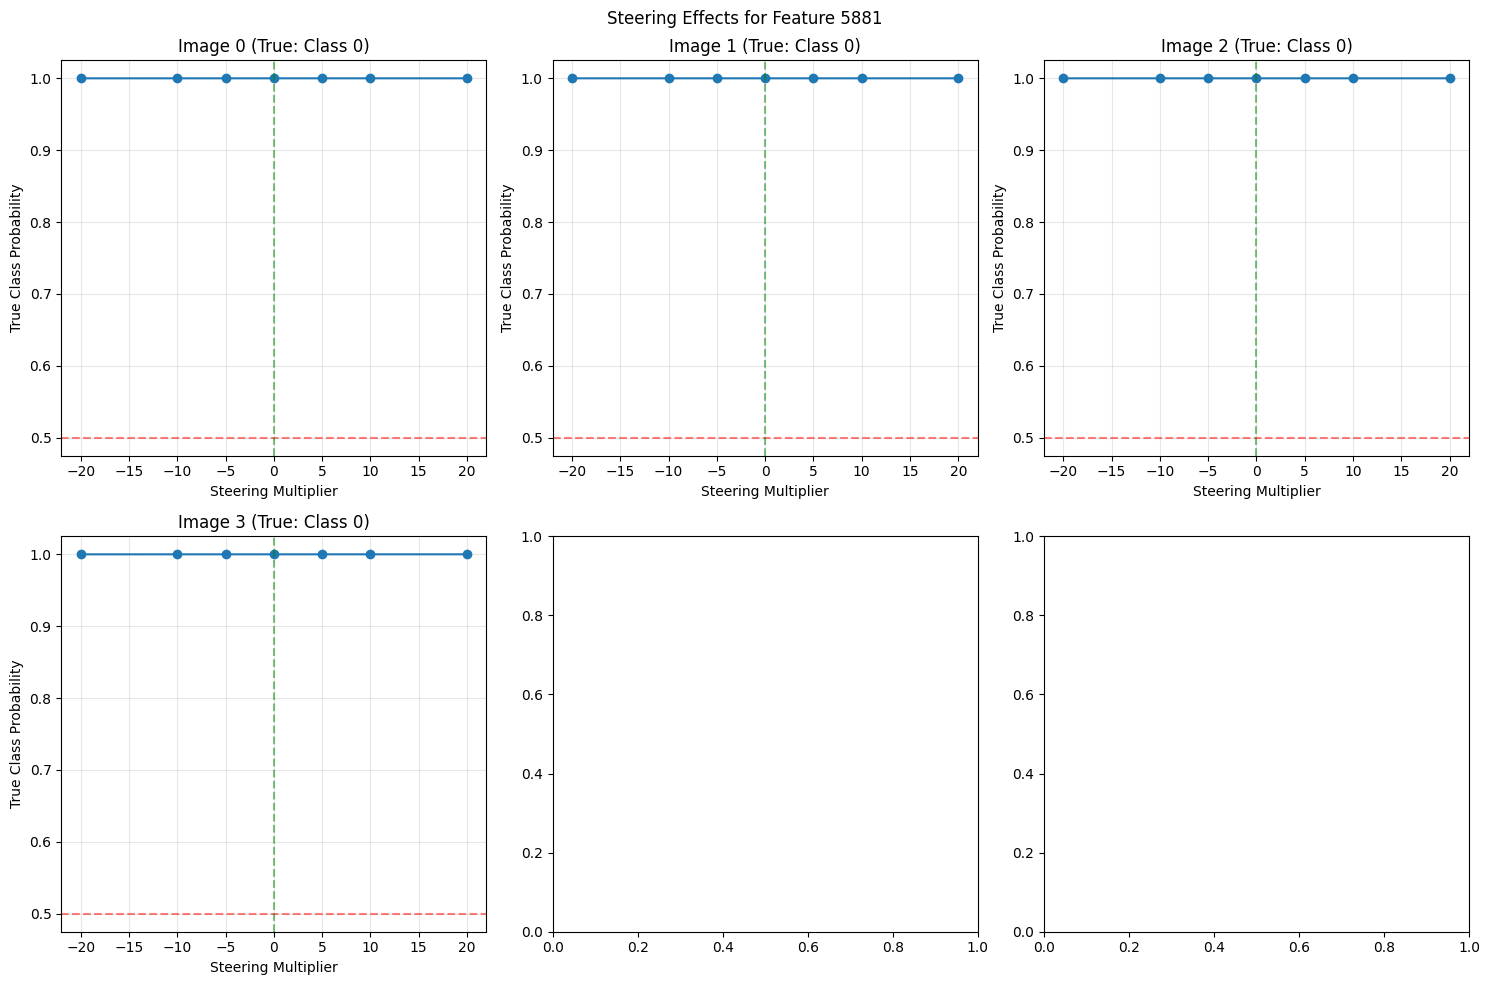

Original prediction: 0
Steered prediction: 0
Probability change: tensor([-6.7353e-05,  6.1439e-07,  6.7502e-05, -3.7729e-07, -2.5992e-07,
        -4.3510e-08], device='cuda:0')


In [5]:
def test_sae_steerability(model, sae, image, feature_idx, multiplier=10.0):
    """
    Test steering by amplifying/suppressing specific SAE features
    """
    with torch.no_grad():
        # 1. Get original predictions
        original_logits = model(image.unsqueeze(0).cuda())
        original_probs = torch.softmax(original_logits, dim=-1)
        original_class = original_logits.argmax(-1).item()
        
        # 2. Forward pass with cache to get activations
        _, cache = model.run_with_cache(
            image.unsqueeze(0).cuda(),
            names_filter=sae.cfg.hook_point
        )
        
        # 3. Get the activation at the hook point (CLS token only)
        acts = cache[sae.cfg.hook_point][:, 0:1, :]  # [batch, 1, d_model]
        
        # 4. Encode to get features
        feature_acts = sae.encode(acts)
        
        # 5. Decode specific feature(s) to get the direction
        feature_direction = sae.W_dec[feature_idx]  # [d_model]
        
        # 6. Create steered activation
        steered_acts = acts.clone()
        steered_acts[0, 0] += multiplier * feature_direction
        
        # 7. Run model from that layer forward with intervention
        steered_logits = model.run_with_hooks(
            image.unsqueeze(0).cuda(),
            fwd_hooks=[(
                sae.cfg.hook_point,
                lambda acts, hook: torch.cat([
                    steered_acts,  # Steered CLS token
                    acts[:, 1:, :]  # Original patch tokens
                ], dim=1)
            )]
        )
        
        steered_probs = torch.softmax(steered_logits, dim=-1)
        steered_class = steered_logits.argmax(-1).item()
        
    return {
        'original_class': original_class,
        'steered_class': steered_class,
        'original_probs': original_probs[0],
        'steered_probs': steered_probs[0],
        'prob_diff': steered_probs[0] - original_probs[0]
}

def find_class_specific_features(model, sae, val_loader, n_batches=1000):
    """Find features that activate strongly for specific classes"""
    class_feature_scores = torch.zeros(6, sae.cfg.d_sae).cuda()
    class_counts = torch.zeros(6).cuda()
    
    with torch.no_grad():
        for i, (imgs, labels) in enumerate(val_loader):
            if i >= n_batches:
                break
                
            # Get activations
            _, cache = model.run_with_cache(
                imgs.cuda(),
                names_filter=sae.cfg.hook_point
            )
            acts = cache[sae.cfg.hook_point][:, 0:1, :]  # CLS only
            
            # Encode
            feature_acts = sae.encode(acts)[1]  # [batch, 1, d_sae]
            
            # Accumulate by class
            for j in range(imgs.shape[0]):
                label = labels[j].item()
                if label < 6:  # Safety check
                    class_feature_scores[label] += feature_acts[j, 0]
                    class_counts[label] += 1
    
    # Check which classes we found
    print("Samples per class:", class_counts.cpu().numpy())
    
    # Normalize
    for i in range(6):
        if class_counts[i] > 0:
            class_feature_scores[i] /= class_counts[i]
    
    # Find most discriminative features
    discriminative_features = {}
    for i in range(6):
        # Features that fire strongly for class i
        top_features = class_feature_scores[i].topk(20)
        
        # Features that fire strongly for i but not others
        other_classes_mean = (class_feature_scores.sum(0) - class_feature_scores[i]) / 5
        discrimination_score = class_feature_scores[i] - other_classes_mean
        most_discriminative = discrimination_score.topk(10)
        
        discriminative_features[i] = {
            'top_features': top_features.indices.tolist(),
            'most_discriminative': most_discriminative.indices.tolist(),
            'discrimination_scores': most_discriminative.values.tolist()
        }
    
    return discriminative_features

def analyze_feature_steerability(model, sae, val_loader, feature_idx, multipliers=[-20, -10, -5, 0, 5, 10, 20]):
    """Test how steering affects class predictions across multiple images"""
    results = []
    
    for imgs, labels in val_loader:
        for i in range(min(5, imgs.shape[0])):  # Test on a few images
            img = imgs[i]
            true_label = labels[i].item()
            
            steering_effects = []
            for mult in multipliers:
                result = test_sae_steerability(model, sae, img, feature_idx, mult)
                steering_effects.append({
                    'multiplier': mult,
                    'prediction': result['steered_class'],
                    'true_class_prob': result['steered_probs'][true_label].item()
                })
            
            results.append({
                'true_label': true_label,
                'original_pred': steering_effects[multipliers.index(0)]['prediction'],
                'steering_effects': steering_effects
            })
        
        break  # Just one batch for quick testing
    
    return results

import matplotlib.pyplot as plt

def plot_steering_effects(results, feature_idx):
    """Visualize how steering affects predictions"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, result in enumerate(results[:6]):
        ax = axes[i]
        
        multipliers = [e['multiplier'] for e in result['steering_effects']]
        true_class_probs = [e['true_class_prob'] for e in result['steering_effects']]
        
        ax.plot(multipliers, true_class_probs, 'o-')
        ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='g', linestyle='--', alpha=0.5)
        
        ax.set_xlabel('Steering Multiplier')
        ax.set_ylabel('True Class Probability')
        ax.set_title(f'Image {i} (True: Class {result["true_label"]})')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Steering Effects for Feature {feature_idx}')
    plt.tight_layout()
    plt.show()

# 1. Find interesting features
discriminative_features = find_class_specific_features(model, sae, val_loader)

# 2. Pick a feature that's specific to, say, class 0
feature_idx = discriminative_features[0]['most_discriminative'][0]
print(f"Testing feature {feature_idx} which is discriminative for class 0")

# 3. Test steerability
results = analyze_feature_steerability(model, sae, val_loader, feature_idx)

# 4. Visualize
plot_steering_effects(results, feature_idx)

# 5. Try on a specific image
test_img, test_label = next(iter(val_loader))
result = test_sae_steerability(model, sae, test_img[3], feature_idx, multiplier=150.0)
print(f"Original prediction: {result['original_class']}")
print(f"Steered prediction: {result['steered_class']}")
print(f"Probability change: {result['prob_diff']}")

In [168]:
# Test discriminative features for each class
for target_class in range(6):
    print(f"\n=== Testing features for Class {target_class} ===")
    
    # Get top discriminative feature for this class
    feature_idx = discriminative_features[target_class]['most_discriminative'][0]
    disc_score = discriminative_features[target_class]['discrimination_scores'][0]
    
    print(f"Using feature {feature_idx} (discrimination score: {disc_score:.3f})")
    print("Steering all non-target class images...")
    
    # Initialize accumulators
    total_original_prob = 0.0
    total_steered_prob = 0.0
    num_samples = 0
    
    # Process entire validation set
    for imgs, labels in test_loader:
        for i in range(imgs.shape[0]):
            # Only process non-target class images
            if labels[i].item() != target_class:
                result = test_sae_steerability(
                    model, sae, imgs[i], 
                    feature_idx, 
                    multiplier=50.0
                )
                
                # Accumulate probabilities for target class
                total_original_prob += result['original_probs'][target_class]
                total_steered_prob += result['steered_probs'][target_class]
                num_samples += 1
    
    # Compute averages
    avg_original = total_original_prob / num_samples
    avg_steered = total_steered_prob / num_samples
    avg_gain = avg_steered - avg_original
    
    # Print summary for this class
    print(f"\nResults for Class {target_class}:")
    print(f"  Non-target images tested: {num_samples}")
    print(f"  Avg original probability: {avg_original:.4f}")
    print(f"  Avg steered probability: {avg_steered:.4f}")
    print(f"  Avg probability gain: {avg_gain:.4f}")
    print(f"  Relative gain: {avg_gain / avg_original:.1%}")



=== Testing features for Class 0 ===
Using feature 4723 (discrimination score: 3.853)
Steering all non-target class images...

Results for Class 0:
  Non-target images tested: 304
  Avg original probability: 0.0075
  Avg steered probability: 0.0106
  Avg probability gain: 0.0031
  Relative gain: 40.6%

=== Testing features for Class 1 ===
Using feature 8 (discrimination score: 0.000)
Steering all non-target class images...

Results for Class 1:
  Non-target images tested: 409
  Avg original probability: 0.0000
  Avg steered probability: 0.0000
  Avg probability gain: 0.0000
  Relative gain: 14.4%

=== Testing features for Class 2 ===
Using feature 4723 (discrimination score: 3.299)
Steering all non-target class images...

Results for Class 2:
  Non-target images tested: 359
  Avg original probability: 0.0124
  Avg steered probability: 0.0111
  Avg probability gain: -0.0013
  Relative gain: -10.7%

=== Testing features for Class 3 ===
Using feature 4723 (discrimination score: 3.079)
St

In [180]:
# Test discriminative features for each class
for target_class in range(6):
    print(f"\n=== Testing features for Class {target_class} ===")
    
    # Get top discriminative feature for this class
    feature_idx = discriminative_features[target_class]['most_discriminative'][0]
    disc_score = discriminative_features[target_class]['discrimination_scores'][0]
    
    print(f"Using feature {feature_idx} (discrimination score: {disc_score:.3f})")
    print("Steering correctly classified target class images...")
    
    # Initialize accumulators
    total_original_prob = 0.0
    total_steered_prob = 0.0
    num_correct = 0
    
    # Process entire validation set
    for imgs, labels in val_loader:
        with torch.no_grad():
            logits = model(imgs.cuda())
            preds = torch.argmax(logits, dim=1)
            probs = torch.softmax(logits, dim=1)
        
        for i in range(imgs.shape[0]):
            # Only process images that:
            # 1. Belong to the target class (true label)
            # 2. Are correctly classified by the model
            if labels[i].item() == target_class and preds[i].item() == target_class:
                result = test_sae_steerability(
                    model, sae, imgs[i], 
                    feature_idx, 
                    multiplier=1000.0
                )
                
                # Accumulate probabilities for target class
                total_original_prob += result['original_probs'][target_class]
                total_steered_prob += result['steered_probs'][target_class]
                num_correct += 1
    
    # Compute averages
    avg_original = total_original_prob / num_correct if num_correct > 0 else 0
    avg_steered = total_steered_prob / num_correct if num_correct > 0 else 0
    avg_gain = avg_steered - avg_original
    
    # Print summary for this class
    print(f"\nResults for Class {target_class}:")
    print(f"  Correct target-class images tested: {num_correct}")
    print(f"  Avg original probability: {avg_original:.4f}")
    print(f"  Avg steered probability: {avg_steered:.4f}")
    print(f"  Avg probability gain: {avg_gain:.4f}")
    print(f"  Relative gain: {avg_gain / avg_original:.1%}" if avg_original > 0 else "  Relative gain: N/A")



=== Testing features for Class 0 ===
Using feature 4723 (discrimination score: 16.988)
Steering correctly classified target class images...

Results for Class 0:
  Correct target-class images tested: 109
  Avg original probability: 0.9977
  Avg steered probability: 0.9794
  Avg probability gain: -0.0183
  Relative gain: -1.8%

=== Testing features for Class 1 ===
Using feature 7 (discrimination score: 0.000)
Steering correctly classified target class images...

Results for Class 1:
  Correct target-class images tested: 0
  Avg original probability: 0.0000
  Avg steered probability: 0.0000
  Avg probability gain: 0.0000
  Relative gain: N/A

=== Testing features for Class 2 ===
Using feature 7 (discrimination score: 0.000)
Steering correctly classified target class images...

Results for Class 2:
  Correct target-class images tested: 32
  Avg original probability: 0.9947
  Avg steered probability: 0.0118
  Avg probability gain: -0.9829
  Relative gain: -98.8%

=== Testing features for 

In [15]:
# Test discriminative features for each class
for target_class in range(6):
    print(f"\n=== Testing features for Class {target_class} ===")
    
    # Get top discriminative feature for this class
    feature_idx = discriminative_features[target_class]['most_discriminative'][0]
    disc_score = discriminative_features[target_class]['discrimination_scores'][0]
    
    print(f"Using feature {feature_idx} (discrimination score: {disc_score:.3f})")
    print("Steering correctly classified target class images...")
    
    # Initialize accumulators for full probability distributions
    total_original_probs = torch.zeros(6).cuda()
    total_steered_probs = torch.zeros(6).cuda()
    num_correct = 0
    
    # Process entire validation set
    for imgs, labels in test_loader:
        imgs = imgs.cuda()
        labels = labels.cuda()
        
        with torch.no_grad():
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
        
        for i in range(imgs.shape[0]):
            # Only process correctly classified target-class images
            if labels[i].item() == target_class:
                result = test_sae_steerability(
                    model, sae, imgs[i], 
                    feature_idx, 
                    multiplier=200.0
                )
                
                # Convert probability lists to tensors
                orig_probs = torch.tensor(result['original_probs']).cuda()
                steered_probs = torch.tensor(result['steered_probs']).cuda()
                
                # Accumulate full probability distributions
                total_original_probs += orig_probs
                total_steered_probs += steered_probs
                num_correct += 1
    
    # Compute average probability distributions
    avg_original_probs = total_original_probs / num_correct if num_correct > 0 else torch.zeros(6)
    avg_steered_probs = total_steered_probs / num_correct if num_correct > 0 else torch.zeros(6)
    delta_probs = avg_steered_probs - avg_original_probs
    
    # Convert to CPU for printing
    avg_original_probs = avg_original_probs.cpu().numpy()
    avg_steered_probs = avg_steered_probs.cpu().numpy()
    delta_probs = delta_probs.cpu().numpy()
    
    # Print summary for this class
    print(f"\nResults for Class {target_class}:")
    print(f"  Correct target-class images tested: {num_correct}")
    
    print("\nClass-wise probability analysis:")
    print(f"{'Class':<6} {'Original':>10} {'Steered':>10} {'Delta':>10}")
    for cls in range(6):
        print(f"{cls:<6} {avg_original_probs[cls]:>10.4f} {avg_steered_probs[cls]:>10.4f} {delta_probs[cls]:>10.4f}", end="")
        if cls == target_class:
            print("  (target)")
        else:
            print()
    
    # Calculate target class specific metrics
    target_gain = delta_probs[target_class]
    target_original = avg_original_probs[target_class]
    relative_gain = target_gain / target_original if target_original > 0 else 0
    
    print(f"\nTarget class ({target_class}) summary:")
    print(f"  Original probability: {target_original:.4f}")
    print(f"  Steered probability: {avg_steered_probs[target_class]:.4f}")
    print(f"  Absolute gain: {target_gain:.4f}")
    print(f"  Relative gain: {relative_gain:.1%}")



=== Testing features for Class 0 ===
Using feature 5881 (discrimination score: 1.772)
Steering correctly classified target class images...


/tmp/ipykernel_8120/1645353337.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_8120/1645353337.py:37: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).




Results for Class 0:
  Correct target-class images tested: 106

Class-wise probability analysis:
Class    Original    Steered      Delta
0          0.9937     0.9982     0.0045  (target)
1          0.0000     0.0000     0.0000
2          0.0063     0.0018    -0.0045
3          0.0000     0.0000    -0.0000
4          0.0000     0.0000    -0.0000
5          0.0000     0.0000    -0.0000

Target class (0) summary:
  Original probability: 0.9937
  Steered probability: 0.9982
  Absolute gain: 0.0045
  Relative gain: 0.5%

=== Testing features for Class 1 ===
Using feature 5175 (discrimination score: 0.537)
Steering correctly classified target class images...

Results for Class 1:
  Correct target-class images tested: 1

Class-wise probability analysis:
Class    Original    Steered      Delta
0          0.9945     0.9975     0.0030
1          0.0002     0.0006     0.0004  (target)
2          0.0051     0.0009    -0.0042
3          0.0000     0.0000    -0.0000
4          0.0001     0.0009    

In [196]:
"""Check what's happening with feature selection"""
print("Feature selection analysis:")
for class_idx in range(6):
    features = discriminative_features[class_idx]['most_discriminative'][:5]
    scores = discriminative_features[class_idx]['discrimination_scores'][:5]
    
    print(f"\nClass {class_idx}:")
    for feat, score in zip(features, scores):
        print(f"  Feature {feat}: score = {score:.3f}")

Feature selection analysis:

Class 0:
  Feature 5881: score = 1.772
  Feature 5175: score = 1.755
  Feature 2393: score = 1.692
  Feature 4614: score = 1.635
  Feature 3616: score = 1.630

Class 1:
  Feature 5175: score = 0.537
  Feature 5179: score = 0.504
  Feature 4165: score = 0.501
  Feature 2676: score = 0.492
  Feature 168: score = 0.414

Class 2:
  Feature 4224: score = 1.503
  Feature 5179: score = 1.461
  Feature 1632: score = 1.144
  Feature 258: score = 1.021
  Feature 168: score = 0.972

Class 3:
  Feature 2255: score = 1.600
  Feature 2676: score = 1.538
  Feature 5873: score = 1.514
  Feature 1789: score = 1.271
  Feature 2824: score = 1.201

Class 4:
  Feature 3029: score = 1.320
  Feature 4018: score = 1.086
  Feature 579: score = 1.079
  Feature 3439: score = 1.009
  Feature 3714: score = 0.975

Class 5:
  Feature 832: score = 3.525
  Feature 2352: score = 3.024
  Feature 3677: score = 2.800
  Feature 5022: score = 2.250
  Feature 5169: score = 2.004


In [167]:
# Test discriminative features for each class
for target_class in range(6):
    print(f"\n=== Testing features for Class {target_class} ===")
    
    # Get top discriminative feature for this class
    feature_idx = discriminative_features[target_class]['most_discriminative'][0]
    disc_score = discriminative_features[target_class]['discrimination_scores'][0]
    
    print(f"Testing feature {feature_idx} (discrimination score: {disc_score:.3f})")
    
    # Test on images from DIFFERENT classes to see if we can steer TO this class
    tested = 0
    for imgs, labels in test_loader:
        for i in range(imgs.shape[0]):
            if labels[i].item() == target_class and tested < 10:  # Test on 3 images NOT from target class
                result = test_sae_steerability(
                    model, sae, imgs[i], 
                    feature_idx, 
                    multiplier=50.0  # Stronger steering
                )
                
                print(f"\nImage from class {labels[i].item()}:")
                print(f"  Original → Steered: {result['original_class']} → {result['steered_class']}")
                print(f"  Target class ({target_class}) prob: {result['original_probs'][target_class]:.4f} → {result['steered_probs'][target_class]:.4f}")
                
                tested += 1
        
        if tested >= 3:
            break


=== Testing features for Class 0 ===
Testing feature 4723 (discrimination score: 3.853)

Image from class 0:
  Original → Steered: 0 → 0
  Target class (0) prob: 1.0000 → 1.0000

Image from class 0:
  Original → Steered: 0 → 0
  Target class (0) prob: 0.9999 → 1.0000

Image from class 0:
  Original → Steered: 0 → 0
  Target class (0) prob: 0.9998 → 1.0000

=== Testing features for Class 1 ===
Testing feature 8 (discrimination score: 0.000)

Image from class 1:
  Original → Steered: 0 → 0
  Target class (1) prob: 0.0002 → 0.0002

=== Testing features for Class 2 ===
Testing feature 4723 (discrimination score: 3.299)

Image from class 2:
  Original → Steered: 2 → 2
  Target class (2) prob: 0.9986 → 0.9962

Image from class 2:
  Original → Steered: 2 → 2
  Target class (2) prob: 0.9987 → 0.9985

Image from class 2:
  Original → Steered: 2 → 2
  Target class (2) prob: 0.9999 → 0.9998

=== Testing features for Class 3 ===
Testing feature 4723 (discrimination score: 3.079)

Image from class

2025-06-12 13:56:05 DEBUG:matplotlib.colorbar: locator: <matplotlib.ticker.AutoLocator object at 0x706369ca87c0>


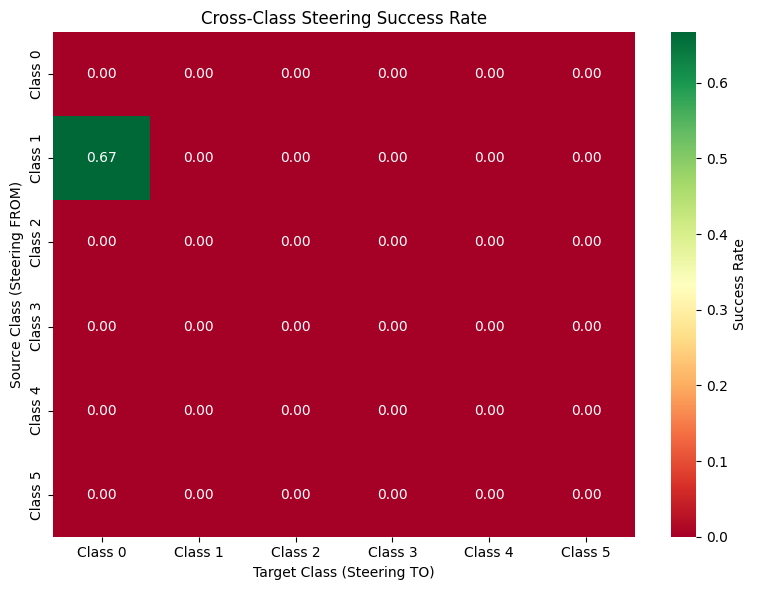

In [177]:
def find_steering_threshold(model, sae, image, source_class, target_class, feature_idx, max_mult=100):
    """Find multiplier needed to change prediction"""
    
    for mult in range(0, max_mult, 5):
        result = test_sae_steerability(model, sae, image, feature_idx, mult)
        
        if result['steered_class'] == target_class:
            print(f"Changed class {source_class} → {target_class} with multiplier {mult}")
            print(f"Probability shift: {result['original_probs'][target_class]:.4f} → {result['steered_probs'][target_class]:.4f}")
            return mult
    
    print(f"Could not change to class {target_class} even with multiplier {max_mult}")
    return None

def test_cross_class_steering(model, sae, val_loader, discriminative_features):
    """Test if we can steer between all class pairs"""
    
    # Create steering matrix
    steering_matrix = torch.zeros(6, 6)
    
    for source_class in range(6):
        # Get a few images from source class
        source_images = []
        for imgs, labels in val_loader:
            for i in range(imgs.shape[0]):
                if labels[i].item() == source_class:
                    source_images.append(imgs[i])
                    if len(source_images) >= 5:
                        break
            if len(source_images) >= 5:
                break
        
        for target_class in range(6):
            if source_class == target_class:
                continue
                
            # Use most discriminative feature for target class
            feature_idx = discriminative_features[target_class]['most_discriminative'][0]
            
            success_count = 0
            for img in source_images[:3]:  # Test on 3 images
                result = test_sae_steerability(model, sae, img, feature_idx, multiplier=75.0)
                if result['steered_class'] == target_class:
                    success_count += 1
            
            steering_matrix[source_class, target_class] = success_count / 3.0
    
    return steering_matrix

import seaborn as sns

def plot_steering_matrix(steering_matrix):
    """Visualize which classes can be steered to which"""
    plt.figure(figsize=(8, 6))
    
    # Create labels for your medical classes
    class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
    # Replace with actual names like ['Polyp', 'Normal', 'Ulcer', etc.]
    
    sns.heatmap(
        steering_matrix, 
        annot=True, 
        fmt='.2f',
        cmap='RdYlGn',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar_kws={'label': 'Success Rate'}
    )
    
    plt.xlabel('Target Class (Steering TO)')
    plt.ylabel('Source Class (Steering FROM)')
    plt.title('Cross-Class Steering Success Rate')
    plt.tight_layout()
    plt.show()

# Run the analysis
steering_matrix = test_cross_class_steering(model, sae, val_loader, discriminative_features)
plot_steering_matrix(steering_matrix)



def steer_with_multiple_features(model, sae, image, feature_indices, multipliers):
    """Steer using multiple features simultaneously"""
    
    with torch.no_grad():
        # Get original activation
        _, cache = model.run_with_cache(
            image.unsqueeze(0).cuda(),
            names_filter=sae.cfg.hook_point
        )
        acts = cache[sae.cfg.hook_point][:, 0:1, :]
        
        # Create steering direction as combination of features
        steering_direction = torch.zeros_like(acts[0, 0])
        for feat_idx, mult in zip(feature_indices, multipliers):
            steering_direction += mult * sae.W_dec[feat_idx]
        
        # Apply steering
        steered_acts = acts.clone()
        steered_acts[0, 0] += steering_direction
        
        # Run model with intervention
        steered_logits = model.run_with_hooks(
            image.unsqueeze(0).cuda(),
            fwd_hooks=[(
                sae.cfg.hook_point,
                lambda acts, hook: torch.cat([
                    steered_acts,
                    acts[:, 1:, :]
                ], dim=1)
            )]
        )
        
        return torch.softmax(steered_logits, dim=-1)[0]

# Example: Suppress class 0 features while boosting class 1 features
class_0_features = discriminative_features[0]['most_discriminative'][:3]
class_1_features = discriminative_features[1]['most_discriminative'][:3]

result = steer_with_multiple_features(
    model, sae, test_img[0],
    feature_indices=class_0_features + class_1_features,
    multipliers=[-30, -30, -30, 30, 30, 30]  # Suppress 0, boost 1
)

In [9]:
from prisma_transmm import transmm_prisma
from config import PipelineConfig
import vit.preprocessing as preprocessing

pipeline_config = PipelineConfig()
pipeline_config.file.current_mode = "val"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_path = "./hyper-kvasir_imagefolder/val/cecum/0b2900bc-e69e-4520-9f19-bda9325b141e.jpg"
_, input_tensor = preprocessing.preprocess_image(str(image_path), img_size=pipeline_config.classify.target_size[0])
input_tensor = input_tensor.to(device)

print(discriminative_features)
print(discriminative_features[0].get('most_discriminative'))

# Assuming you have an `image_tensor` and `pipeline_config`
pred_dict, attr_map = transmm_prisma(
    model_prisma=model,
    input_tensor=input_tensor,
    config=pipeline_config,
    sae=sae,
    discriminative_features=discriminative_features
)

print(attr_map)

{0: {'top_features': [4723, 5301, 1196, 5590, 254, 3577, 5765, 4225, 262, 2965, 3496, 5240, 2793, 2179, 3487, 675, 1487, 1382, 4056, 1746], 'most_discriminative': [5881, 5175, 2393, 4614, 3616, 5043, 5538, 5179, 165, 4494], 'discrimination_scores': [1.5936660766601562, 1.5924112796783447, 1.5184619426727295, 1.4925243854522705, 1.4731762409210205, 1.4432978630065918, 1.3916730880737305, 1.3629190921783447, 1.3192126750946045, 1.3140950202941895]}, 1: {'top_features': [4723, 5301, 1196, 5590, 254, 3577, 5765, 4225, 262, 2965, 5240, 3496, 2179, 2793, 3487, 675, 1487, 1382, 4056, 1746], 'most_discriminative': [5175, 5881, 5179, 4614, 3616, 2393, 5043, 5538, 168, 165], 'discrimination_scores': [1.4725418090820312, 1.4531015157699585, 1.364741563796997, 1.350252389907837, 1.3500875234603882, 1.3488470315933228, 1.3040084838867188, 1.2639589309692383, 1.193950891494751, 1.1935633420944214]}, 2: {'top_features': [4723, 5301, 1196, 3577, 5590, 254, 5765, 262, 4225, 2965, 5240, 2793, 3487, 3496

ValueError: 'layer_idx' and 'features' are required in steering_options

In [4]:
from vit.attribution import transmm
import vit.model

vit_model = vit.model.load_vit_model(model_path="./model/vit_b_hyperkvasir_anatomical_for_translrp.pth", device=device)

pred_dict, attr_map_old, _, _, _, _ = transmm(
    model_nn=vit_model,
    input_tensor=input_tensor,
    config=pipeline_config,
)

print(attr_map_old)


Loading weights from ./model/vit_b_hyperkvasir_anatomical_for_translrp.pth
Checkpoint keys: ['cls_token', 'pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'bl

In [16]:
print(discriminative_features[4])

{'top_features': [4723, 5301, 1196, 3577, 5590, 254, 5765, 262, 5240, 2965, 3487, 4225, 2179, 2793, 1487, 675, 3496, 1382, 1746, 436], 'most_discriminative': [3029, 4018, 579, 3439, 3714, 5179, 3824, 1382, 4537, 3487], 'discrimination_scores': [1.3198041915893555, 1.085694670677185, 1.079262137413025, 1.0087217092514038, 0.9748423099517822, 0.7006464004516602, 0.686370849609375, 0.6763434410095215, 0.6533992886543274, 0.6303119659423828]}


In [12]:
class_feature_map = {
    class_idx: data['most_discriminative'][0]
    for class_idx, data in discriminative_features.items() if data['most_discriminative']
}

print(class_feature_map)

{0: 5881, 1: 5175, 2: 4224, 3: 2255, 4: 3029, 5: 832}
